# Phase 2b: Per-Chunk Diagnostic Analysis

## Objectives

1. **Analyze individual chunk quality** - Understand how each raw daily chunk performs after alpha scaling
2. **Validate per-chunk patterns** - Compare scaled chunks to weekly ground truth for matching periods
3. **Identify problematic chunks** - Flag chunks with poor correlation, high error, or alpha outliers
4. **Error attribution** - Decompose overall error to understand which chunks contribute most

## Methodology

For each raw daily chunk:
1. Scale by estimated alpha (from hierarchical optimization)
2. Aggregate to weekly (resample 'W-SUN')
3. Compare to weekly ground truth for matching date range
4. Compute metrics: Correlation, NMAE, Bias%, MAE

## Important Notes

- **This is a diagnostic tool**, not primary validation
- Weekly MAE on full stitched series remains the primary validation metric
- Per-chunk metrics help identify data quality issues and error sources
- Expected: Most chunks should have correlation > 0.85, NMAE < 5%, bias% within ±10%

## Outputs

- `reports/chunk_diagnostics_hierarchical.txt` - Per-chunk summary table
- `reports/chunk_diagnostics_hierarchical.csv` - Exportable metrics
- `reports/chunk_quality_heatmap.png` - Visual quality matrix
- `reports/chunk_alpha_timeline.png` - Alpha values over time
- `reports/chunk_error_decomposition.png` - Error attribution by chunk
- `reports/chunk_overlap_analysis.png` - Overlap region analysis

# Results  

## Google Trends normalization is NOT additive/scalable
- Raw chunk for Jan-Sep: normalized to [0-100] for that period
- Weekly ground truth for Jan-Sep: normalized to [0-100] relative to entire 2022-2024 range
- Simply multiplying by alpha cannot reconcile these different normalization contexts

## The per-chunk validation is methodologically flawed for this use case
❌ NMAE and Bias% values are NOT meaningful (scale mismatch)  
❌ Cannot use per-chunk metrics as quality thresholds  
❌ High bias doesn't indicate "bad" chunks - it indicates scale incompatibility  

## 1. Setup and Imports

In [2]:
# Add src to path
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

print(f"Project root: {project_root}")

Project root: /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing


In [3]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from loguru import logger
from datetime import datetime
from scipy.stats import pearsonr

# Project imports
from config import ConfigManager
from utils import FileManager, setup_logger
from stitching.base import StitchingResult

# Plotting configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✓ Imports successful")

✓ Imports successful


In [4]:
# Load configuration
config = ConfigManager(config_path=project_root / "config.yaml")
fm = FileManager(project_root)
fm.ensure_directories()

# Setup logger with proper file path
log_file = fm.get_log_path("chunk_diagnostics.log")
logger = setup_logger(log_file, level="INFO")

# Display configuration
print(config.summary())

logger.info(f"Starting chunk diagnostics for term: {config.search_term}")

2025-11-13 00:01:44.942 | WARNING  | config:__init__:223 - Environment file not found: .env
2025-11-13 00:01:44.945 | INFO     | config:__init__:232 - Loaded configuration from /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/config.yaml
2025-11-13 00:01:44.946 | SUCCESS  | config:_parse_config:319 - Configuration validated successfully
2025-11-13 00:01:44.947 | INFO     | utils:ensure_directories:50 - Ensured all directories exist under /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing
2025-11-13 00:01:44 | INFO     | Logging to file: /home/mikhailarutyunov/projects/google-trends-daily-data-preprocessing/logs/chunk_diagnostics.log
2025-11-13 00:01:44 | INFO     | Starting chunk diagnostics for term: flu vaccine


Configuration Summary
Search Term: flu vaccine
Geographic Location: GB
Date Range: 2022-01-01 to 2024-12-31 (1096 days)
Overlap: 60 days
Random Seed: 42

Stitching Weights:
  Monthly: 1.0
  Weekly: 0.5
  Overlap: 0.1

Zero Handling:
  Threshold: 0.01
  Structural Zero Months: [6, 7, 8]

Optimization:
  Max Iterations: 1000
  Tolerance: 1e-08

SerpAPI:
  Timeout: 90s
  Max Retries: 3
  Retry Delay: 10s


## 2. Load Data

In [5]:
# Load hierarchical stitching results
logger.info("Loading hierarchical stitching results...")

result = StitchingResult.load(fm, "hierarchical")
stitched_daily = result.stitched_series
alphas = result.alpha_estimates
diagnostics = result.diagnostics

print(f"✓ Loaded stitched series: {len(stitched_daily)} days")
print(f"✓ Loaded alpha estimates: {len(alphas)} chunks")
print(f"✓ Overall Weekly MAE: {diagnostics['weekly_mae']:.2f}")
print(f"✓ Alpha CV: {diagnostics['alpha_cv']:.1f}%")

# Display alpha values
print("\nAlpha estimates per chunk:")
for i, alpha in enumerate(alphas):
    print(f"  Chunk {i}: α = {alpha:.4f}")

2025-11-13 00:01:46 | INFO     | Loading hierarchical stitching results...
2025-11-13 00:01:46 | INFO     | Loaded stitching results for hierarchical


✓ Loaded stitched series: 1096 days
✓ Loaded alpha estimates: 6 chunks
✓ Overall Weekly MAE: 0.36
✓ Alpha CV: 0.8%

Alpha estimates per chunk:
  Chunk 0: α = 0.1085
  Chunk 1: α = 0.3874
  Chunk 2: α = 0.0094
  Chunk 3: α = 0.2718
  Chunk 4: α = 0.2064
  Chunk 5: α = 0.0215


In [6]:
# Load raw daily chunks
logger.info("Loading raw daily chunks...")

chunks = []
chunk_idx = 0

while True:
    chunk_path = fm.get_daily_chunk_path(chunk_idx)
    if not chunk_path.exists():
        break

    chunk = pd.read_parquet(chunk_path)
    chunk["date"] = pd.to_datetime(chunk["date"])
    chunks.append(chunk)
    print(f"✓ Loaded chunk_{chunk_idx:02d}: {len(chunk)} days, {chunk['date'].min()} to {chunk['date'].max()}")
    chunk_idx += 1

if not chunks:
    raise FileNotFoundError(
        f"No daily chunks found in {fm.data_daily_chunks}. "
        "Please run notebook 01_data_collection.ipynb first."
    )

num_chunks = len(chunks)
print(f"\nTotal chunks loaded: {num_chunks}")

2025-11-13 00:01:46 | INFO     | Loading raw daily chunks...


✓ Loaded chunk_00: 266 days, 2022-01-01 00:00:00 to 2022-09-23 00:00:00
✓ Loaded chunk_01: 266 days, 2022-07-26 00:00:00 to 2023-04-17 00:00:00
✓ Loaded chunk_02: 266 days, 2023-02-17 00:00:00 to 2023-11-09 00:00:00
✓ Loaded chunk_03: 266 days, 2023-09-11 00:00:00 to 2024-06-02 00:00:00
✓ Loaded chunk_04: 266 days, 2024-04-04 00:00:00 to 2024-12-25 00:00:00
✓ Loaded chunk_05: 66 days, 2024-10-27 00:00:00 to 2024-12-31 00:00:00

Total chunks loaded: 6


In [7]:
# Load weekly ground truth
logger.info("Loading weekly ground truth...")

weekly_path = fm.get_raw_data_path("weekly")
if not weekly_path.exists():
    raise FileNotFoundError(
        f"Weekly data not found at {weekly_path}. "
        "Please run notebook 01_data_collection.ipynb first."
    )

weekly_truth = pd.read_parquet(weekly_path)
weekly_truth["date"] = pd.to_datetime(weekly_truth["date"])

print(f"✓ Loaded weekly ground truth: {len(weekly_truth)} weeks")
print(f"  Date range: {weekly_truth['date'].min()} to {weekly_truth['date'].max()}")
print(f"  Day of week: {weekly_truth['date'].dt.day_name().unique()[0]} (should be Sunday)")

2025-11-13 00:01:46 | INFO     | Loading weekly ground truth...


✓ Loaded weekly ground truth: 158 weeks
  Date range: 2021-12-26 00:00:00 to 2024-12-29 00:00:00
  Day of week: Sunday (should be Sunday)


## 3. Build Daily Index (Date-Chunk Mapping)

In [8]:
# Rebuild daily_index to track which chunks cover which dates
logger.info("Building daily index (date-chunk mapping)...")

all_data = []
for chunk_id, chunk in enumerate(chunks):
    chunk_copy = chunk.copy()
    chunk_copy["date"] = pd.to_datetime(chunk_copy["date"])
    chunk_copy["chunk_id"] = chunk_id
    all_data.append(chunk_copy[["date", "value", "chunk_id"]])

daily_index = pd.concat(all_data, ignore_index=True)
daily_index = daily_index.sort_values(["date", "chunk_id"]).reset_index(drop=True)

print(f"✓ Daily index built: {len(daily_index)} rows")
print(f"  Unique dates: {daily_index['date'].nunique()}")
print(f"  Date range: {daily_index['date'].min()} to {daily_index['date'].max()}")

# Identify overlap dates (dates covered by multiple chunks)
date_counts = daily_index.groupby("date").size()
overlap_dates = date_counts[date_counts > 1].index
print(f"  Overlap dates: {len(overlap_dates)} dates covered by 2+ chunks")

2025-11-13 00:01:48 | INFO     | Building daily index (date-chunk mapping)...


✓ Daily index built: 1396 rows
  Unique dates: 1096
  Date range: 2022-01-01 00:00:00 to 2024-12-31 00:00:00
  Overlap dates: 300 dates covered by 2+ chunks


## 4. Per-Chunk Validation Function

In [9]:
def validate_chunk_against_weekly(chunk_id, chunk_df, alpha, weekly_truth):
    """
    Validate a single chunk against weekly ground truth.

    Steps:
    1. Scale chunk by alpha
    2. Aggregate to weekly (W-SUN)
    3. Merge with weekly truth for matching dates
    4. Calculate metrics: Correlation, NMAE, Bias%, MAE

    Returns:
        dict with metrics and comparison DataFrame
    """
    # Step 1: Scale chunk
    scaled_chunk = chunk_df.copy()
    scaled_chunk["value"] = scaled_chunk["value"] * alpha

    # Step 2: Aggregate to weekly
    scaled_chunk = scaled_chunk.set_index("date")
    chunk_weekly = scaled_chunk["value"].resample("W-SUN").sum().reset_index()
    chunk_weekly.columns = ["date", "stitched"]

    # Step 3: Merge with weekly truth
    weekly_truth_copy = weekly_truth.rename(columns={"value": "truth"})
    comparison = pd.merge(
        weekly_truth_copy[["date", "truth"]],
        chunk_weekly,
        on="date",
        how="inner"
    )

    # Check if we have data
    if len(comparison) == 0:
        return {
            "chunk_id": chunk_id,
            "num_weeks": 0,
            "correlation": np.nan,
            "mae": np.nan,
            "nmae": np.nan,
            "bias_pct": np.nan,
            "comparison": comparison
        }

    # Step 4: Calculate metrics
    comparison["error"] = comparison["stitched"] - comparison["truth"]
    comparison["abs_error"] = comparison["error"].abs()

    # MAE
    mae = comparison["abs_error"].mean()

    # Correlation
    if len(comparison) > 1:
        corr, _ = pearsonr(comparison["truth"], comparison["stitched"])
    else:
        corr = np.nan

    # NMAE (Normalized MAE)
    truth_range = comparison["truth"].max() - comparison["truth"].min()
    nmae = (mae / truth_range * 100) if truth_range > 0 else np.nan

    # Bias %
    bias = comparison["error"].mean()
    bias_pct = (bias / comparison["truth"].mean() * 100) if comparison["truth"].mean() > 0 else np.nan

    return {
        "chunk_id": chunk_id,
        "num_weeks": len(comparison),
        "correlation": corr,
        "mae": mae,
        "nmae": nmae,
        "bias_pct": bias_pct,
        "comparison": comparison
    }


print("✓ Validation function defined")

✓ Validation function defined


## 5. Run Per-Chunk Validation

In [10]:
# Validate each chunk
logger.info("Running per-chunk validation...")

chunk_validations = []

for chunk_id, chunk in enumerate(chunks):
    alpha = alphas[chunk_id]

    validation = validate_chunk_against_weekly(chunk_id, chunk, alpha, weekly_truth)
    chunk_validations.append(validation)

    print(f"Chunk {chunk_id}: α={alpha:.4f}, Weeks={validation['num_weeks']}, "
          f"Corr={validation['correlation']:.3f}, MAE={validation['mae']:.2f}, "
          f"NMAE={validation['nmae']:.1f}%, Bias={validation['bias_pct']:+.1f}%")

print(f"\n✓ Validated {len(chunk_validations)} chunks")

2025-11-13 00:01:53 | INFO     | Running per-chunk validation...


Chunk 0: α=0.1085, Weeks=39, Corr=0.952, MAE=0.22, NMAE=5.1%, Bias=-42.9%
Chunk 1: α=0.3874, Weeks=39, Corr=0.946, MAE=0.51, NMAE=11.7%, Bias=+32.6%
Chunk 2: α=0.0094, Weeks=39, Corr=0.965, MAE=0.88, NMAE=20.3%, Bias=-95.1%
Chunk 3: α=0.2718, Weeks=38, Corr=0.972, MAE=0.60, NMAE=13.9%, Bias=+58.8%
Chunk 4: α=0.2064, Weeks=39, Corr=0.949, MAE=0.36, NMAE=7.9%, Bias=+14.1%
Chunk 5: α=0.0215, Weeks=10, Corr=0.013, MAE=1.19, NMAE=77.9%, Bias=-78.1%

✓ Validated 6 chunks


## 6. Compute Chunk Statistics

In [11]:
# Calculate raw chunk statistics
logger.info("Computing raw chunk statistics...")

chunk_stats = []

for chunk_id, chunk in enumerate(chunks):
    stats = {
        "chunk_id": chunk_id,
        "start_date": chunk["date"].min(),
        "end_date": chunk["date"].max(),
        "num_days": len(chunk),
        "mean_value": chunk["value"].mean(),
        "std_value": chunk["value"].std(),
        "min_value": chunk["value"].min(),
        "max_value": chunk["value"].max(),
        "zero_count": (chunk["value"] == 0).sum(),
        "zero_pct": (chunk["value"] == 0).mean() * 100,
    }
    chunk_stats.append(stats)

chunk_stats_df = pd.DataFrame(chunk_stats)
print("✓ Chunk statistics computed")
print(f"\nChunk Statistics Summary:")
print(chunk_stats_df.to_string(index=False))

2025-11-13 00:01:59 | INFO     | Computing raw chunk statistics...


✓ Chunk statistics computed

Chunk Statistics Summary:
 chunk_id start_date   end_date  num_days  mean_value  std_value  min_value  max_value  zero_count  zero_pct
        0 2022-01-01 2022-09-23       266    0.381283   0.616380   0.000000   4.648084          81 30.451128
        1 2022-07-26 2023-04-17       266    0.627491   0.714318   0.000000   4.648084          37 13.909774
        2 2023-02-17 2023-11-09       266    0.709794   1.093241   0.000000   4.648084          99 37.218045
        3 2023-09-11 2024-06-02       266    0.799610   1.071573   0.000000   4.648084          78 29.323308
        4 2024-04-04 2024-12-25       266    0.920181   1.176933   0.000000   4.648084          85 31.954887
        5 2024-10-27 2024-12-31        66    2.403623   0.965562   0.790174   4.648084           0  0.000000


In [12]:
# Compute error attribution (which chunks contribute most to overall error)
logger.info("Computing error attribution...")

# Join stitched series with daily_index to see contribution per chunk
stitched_with_chunks = daily_index.copy()
stitched_with_chunks = stitched_with_chunks.merge(
    stitched_daily[["date", "value"]].rename(columns={"value": "stitched_value"}),
    on="date",
    how="inner"
)

# Scale raw values by alpha
stitched_with_chunks["alpha"] = stitched_with_chunks["chunk_id"].map(
    {i: alphas[i] for i in range(len(alphas))}
)
stitched_with_chunks["scaled_raw"] = stitched_with_chunks["value"] * stitched_with_chunks["alpha"]

# Set date as index for resampling
stitched_with_chunks = stitched_with_chunks.set_index("date")

# Aggregate to weekly using resample (same method as validation function)
chunk_weekly_contrib = stitched_with_chunks.groupby("chunk_id").resample("W-SUN").agg({
    "scaled_raw": "sum",
    "stitched_value": "sum"
}).reset_index()

# Rename 'date' column to 'week_date' for clarity
chunk_weekly_contrib = chunk_weekly_contrib.rename(columns={"date": "week_date"})

# Merge with weekly truth
chunk_weekly_contrib = chunk_weekly_contrib.merge(
    weekly_truth[["date", "value"]].rename(columns={"date": "week_date", "value": "truth"}),
    on="week_date",
    how="inner"
)

print(f"  Matched {len(chunk_weekly_contrib)} chunk-week pairs with ground truth")

# Calculate error
chunk_weekly_contrib["error"] = chunk_weekly_contrib["stitched_value"] - chunk_weekly_contrib["truth"]
chunk_weekly_contrib["abs_error"] = chunk_weekly_contrib["error"].abs()

# Aggregate by chunk
error_attribution = chunk_weekly_contrib.groupby("chunk_id").agg({
    "abs_error": ["mean", "sum", "count"]
}).reset_index()
error_attribution.columns = ["chunk_id", "mae_contrib", "total_error", "num_weeks"]

print("✓ Error attribution computed")
print(f"\nError Attribution by Chunk:")
print(error_attribution.to_string(index=False))

2025-11-13 00:01:59 | INFO     | Computing error attribution...


  Matched 204 chunk-week pairs with ground truth
✓ Error attribution computed

Error Attribution by Chunk:
 chunk_id  mae_contrib  total_error  num_weeks
        0     0.178362     6.956125         39
        1     0.555743    21.673972         39
        2     0.357140    13.928456         39
        3     0.310621    11.803593         38
        4     0.328958    12.829379         39
        5     0.574046     5.740457         10


In [13]:
# Analyze overlap regions
logger.info("Analyzing overlap regions...")

overlap_analysis = []

# For each overlap date, compare raw values between chunks
for date in overlap_dates:
    date_data = daily_index[daily_index["date"] == date]

    if len(date_data) == 2:
        chunk_ids = date_data["chunk_id"].values
        values = date_data["value"].values

        # Scale by alphas
        scaled_values = [values[i] * alphas[chunk_ids[i]] for i in range(2)]

        overlap_analysis.append({
            "date": date,
            "chunk1_id": chunk_ids[0],
            "chunk2_id": chunk_ids[1],
            "raw1": values[0],
            "raw2": values[1],
            "scaled1": scaled_values[0],
            "scaled2": scaled_values[1],
            "raw_diff": abs(values[0] - values[1]),
            "scaled_diff": abs(scaled_values[0] - scaled_values[1]),
            "scaled_diff_pct": abs(scaled_values[0] - scaled_values[1]) / max(scaled_values) * 100 if max(scaled_values) > 0 else 0
        })

overlap_df = pd.DataFrame(overlap_analysis)

if len(overlap_df) > 0:
    print(f"✓ Overlap analysis computed: {len(overlap_df)} overlap dates")
    print(f"\nOverlap Statistics:")
    print(f"  Mean scaled difference: {overlap_df['scaled_diff'].mean():.2f}")
    print(f"  Mean scaled difference %: {overlap_df['scaled_diff_pct'].mean():.1f}%")
    print(f"  Max scaled difference: {overlap_df['scaled_diff'].max():.2f}")
    print(f"  Dates with >20% difference: {(overlap_df['scaled_diff_pct'] > 20).sum()}")
else:
    print("✓ No overlap dates found")

2025-11-13 00:01:59 | INFO     | Analyzing overlap regions...


✓ Overlap analysis computed: 300 overlap dates

Overlap Statistics:
  Mean scaled difference: 0.19
  Mean scaled difference %: 58.8%
  Max scaled difference: 1.22
  Dates with >20% difference: 230


## 7. Consolidate Results

In [14]:
# Combine all chunk-level data into one DataFrame
logger.info("Consolidating results...")

# Extract validation metrics
validation_df = pd.DataFrame([{
    "chunk_id": v["chunk_id"],
    "num_weeks": v["num_weeks"],
    "correlation": v["correlation"],
    "mae": v["mae"],
    "nmae": v["nmae"],
    "bias_pct": v["bias_pct"]
} for v in chunk_validations])

# Add alpha values
validation_df["alpha"] = alphas

# Merge with chunk stats
chunk_results = chunk_stats_df.merge(validation_df, on="chunk_id")

# Merge with error attribution (use left join to keep all chunks even if no error data)
if len(error_attribution) > 0:
    chunk_results = chunk_results.merge(error_attribution, on="chunk_id", how="left", suffixes=("", "_error"))
else:
    # If error attribution is empty, add columns with NaN
    chunk_results["mae_contrib"] = np.nan
    chunk_results["total_error"] = np.nan
    chunk_results["num_weeks_error"] = np.nan

# Flag outliers
chunk_results["alpha_outlier"] = (chunk_results["alpha"] < 0.1) | (chunk_results["alpha"] > 10)
chunk_results["low_correlation"] = chunk_results["correlation"] < 0.85
chunk_results["high_nmae"] = chunk_results["nmae"] > 5.0
chunk_results["high_bias"] = chunk_results["bias_pct"].abs() > 10.0

# Add flag summary
chunk_results["flags"] = (
    chunk_results["alpha_outlier"].astype(int) +
    chunk_results["low_correlation"].astype(int) +
    chunk_results["high_nmae"].astype(int) +
    chunk_results["high_bias"].astype(int)
)

print("✓ Results consolidated")
print(f"\nChunk Quality Summary:")
display_cols = ["chunk_id", "start_date", "end_date", "alpha", "correlation", "nmae", "bias_pct", "flags"]
if "mae_contrib" in chunk_results.columns and not chunk_results["mae_contrib"].isna().all():
    display_cols.insert(-1, "mae_contrib")
print(chunk_results[display_cols].to_string(index=False))

2025-11-13 00:02:08 | INFO     | Consolidating results...


✓ Results consolidated

Chunk Quality Summary:
 chunk_id start_date   end_date    alpha  correlation      nmae   bias_pct  mae_contrib  flags
        0 2022-01-01 2022-09-23 0.108547     0.952483  5.106009 -42.927801     0.178362      2
        1 2022-07-26 2023-04-17 0.387442     0.946457 11.675450  32.631319     0.555743      2
        2 2023-02-17 2023-11-09 0.009410     0.965456 20.313696 -95.068095     0.357140      3
        3 2023-09-11 2024-06-02 0.271787     0.972369 13.862103  58.837306     0.310621      2
        4 2024-04-04 2024-12-25 0.206357     0.949171  7.919644  14.146489     0.328958      2
        5 2024-10-27 2024-12-31 0.021453     0.012506 77.879856 -78.116573     0.574046      4


## 8. Visualizations

### 8.1 Chunk Quality Heatmap

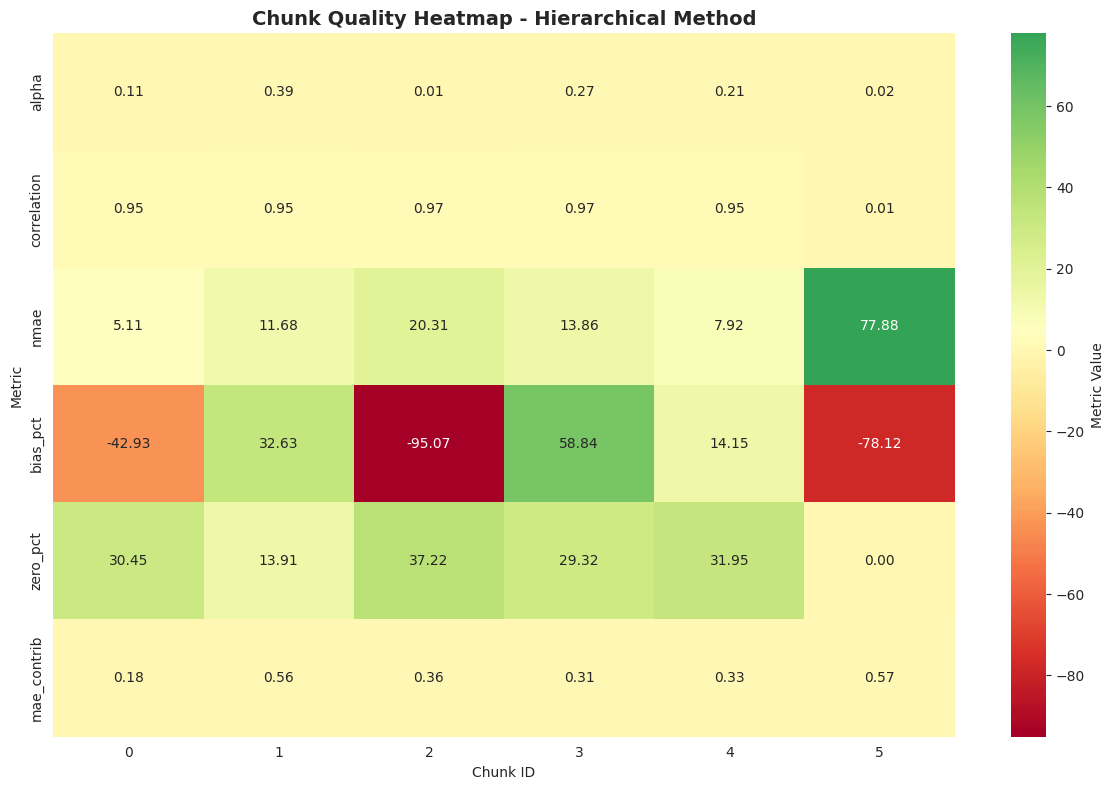

In [15]:
# Create quality heatmap
fig, ax = plt.subplots(figsize=(12, 8))

# Select metrics for heatmap (exclude mae_contrib if all NaN)
heatmap_cols = ["chunk_id", "alpha", "correlation", "nmae", "bias_pct", "zero_pct"]
if "mae_contrib" in chunk_results.columns and not chunk_results["mae_contrib"].isna().all():
    heatmap_cols.append("mae_contrib")

heatmap_data = chunk_results[heatmap_cols].set_index("chunk_id").T

# Normalize each metric to [0, 1] for visualization
heatmap_normalized = heatmap_data.copy()
for idx in heatmap_normalized.index:
    row = heatmap_normalized.loc[idx]
    if row.max() != row.min():
        heatmap_normalized.loc[idx] = (row - row.min()) / (row.max() - row.min())

# Plot
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    center=heatmap_data.values.mean(),
    ax=ax,
    cbar_kws={"label": "Metric Value"}
)

ax.set_xlabel("Chunk ID")
ax.set_ylabel("Metric")
ax.set_title("Chunk Quality Heatmap - Hierarchical Method", fontsize=14, fontweight="bold")

plt.tight_layout()
heatmap_path = fm.get_report_path("chunk_quality_heatmap.png")
# fig.savefig(heatmap_path, dpi=300, bbox_inches="tight")
# print(f"✓ Saved: {heatmap_path}")
plt.show()

### 8.2 Alpha Timeline

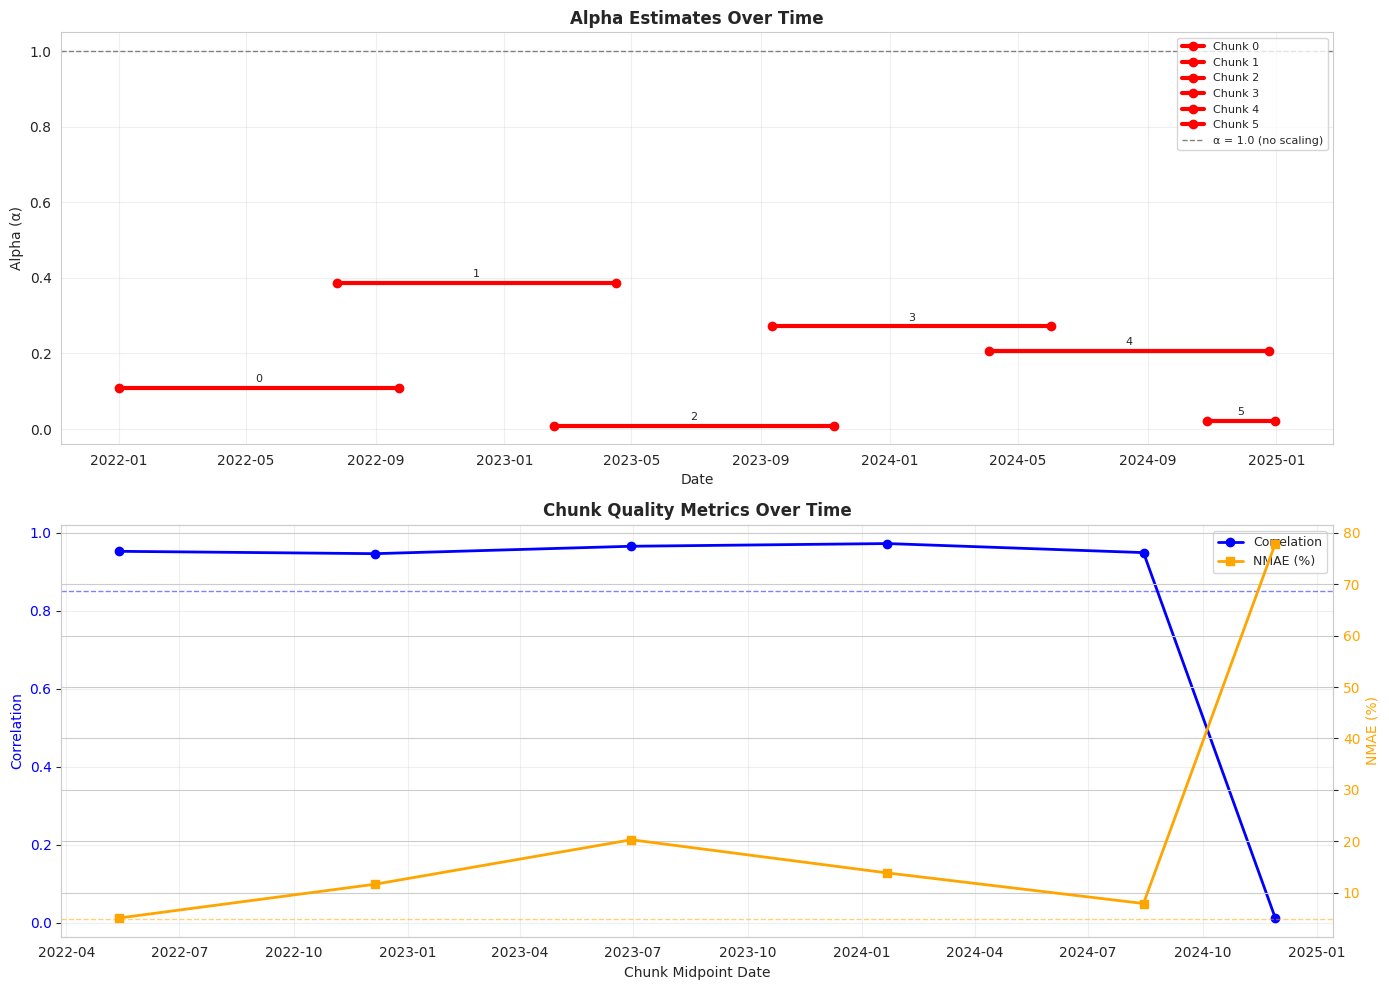

In [16]:
# Plot alpha values over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Subplot 1: Alpha values with chunk date ranges
for _, row in chunk_results.iterrows():
    chunk_id = row["chunk_id"]
    start = row["start_date"]
    end = row["end_date"]
    alpha = row["alpha"]

    # Color based on flags
    color = "red" if row["flags"] > 0 else "green"

    ax1.plot([start, end], [alpha, alpha], marker="o", linewidth=3, color=color, label=f"Chunk {chunk_id}")
    ax1.text((start + (end - start) / 2), alpha + 0.01, f"{chunk_id}", ha="center", va="bottom", fontsize=8)

ax1.axhline(y=1.0, color="gray", linestyle="--", linewidth=1, label="α = 1.0 (no scaling)")
ax1.set_xlabel("Date")
ax1.set_ylabel("Alpha (α)")
ax1.set_title("Alpha Estimates Over Time", fontsize=12, fontweight="bold")
ax1.grid(True, alpha=0.3)
ax1.legend(loc="upper right", fontsize=8)

# Subplot 2: Chunk quality metrics over time
chunk_midpoints = chunk_results.apply(
    lambda row: row["start_date"] + (row["end_date"] - row["start_date"]) / 2, axis=1
)

ax2_twin = ax2.twinx()

ax2.plot(chunk_midpoints, chunk_results["correlation"], marker="o", linewidth=2, color="blue", label="Correlation")
ax2.axhline(y=0.85, color="blue", linestyle="--", linewidth=1, alpha=0.5)

ax2_twin.plot(chunk_midpoints, chunk_results["nmae"], marker="s", linewidth=2, color="orange", label="NMAE (%)")
ax2_twin.axhline(y=5.0, color="orange", linestyle="--", linewidth=1, alpha=0.5)

ax2.set_xlabel("Chunk Midpoint Date")
ax2.set_ylabel("Correlation", color="blue")
ax2_twin.set_ylabel("NMAE (%)", color="orange")
ax2.set_title("Chunk Quality Metrics Over Time", fontsize=12, fontweight="bold")
ax2.tick_params(axis="y", labelcolor="blue")
ax2_twin.tick_params(axis="y", labelcolor="orange")
ax2.grid(True, alpha=0.3)

# Combine legends
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper right", fontsize=9)

plt.tight_layout()
timeline_path = fm.get_report_path("chunk_alpha_timeline.png")
# fig.savefig(timeline_path, dpi=300, bbox_inches="tight")
# print(f"✓ Saved: {timeline_path}")
plt.show()

### 8.3 Error Decomposition

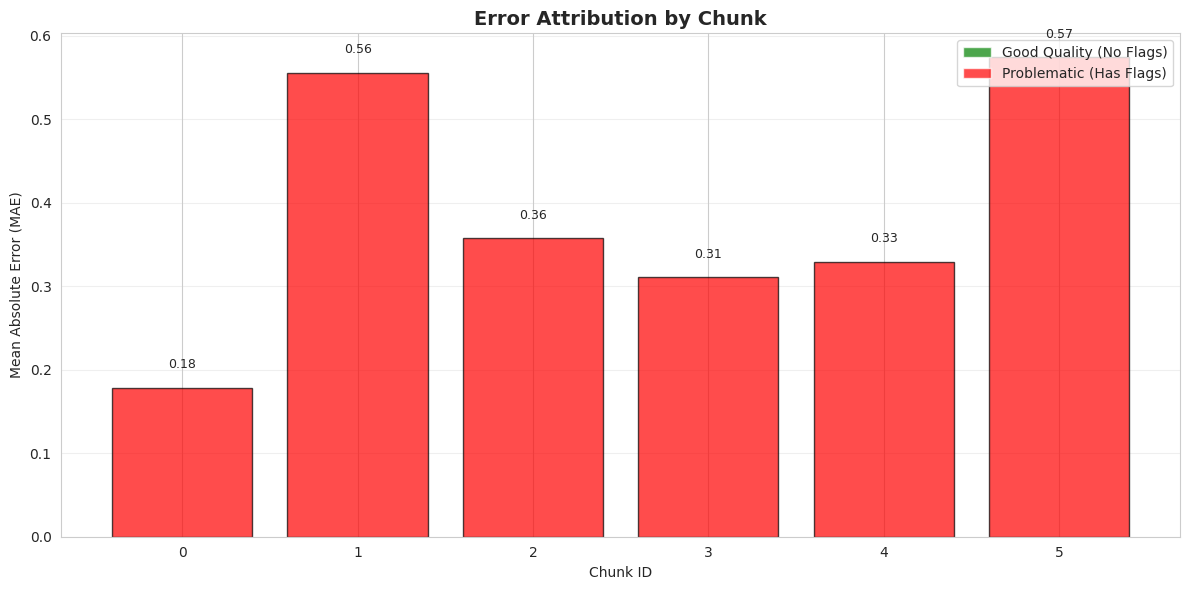

In [17]:
# Bar chart of error contribution by chunk
fig, ax = plt.subplots(figsize=(12, 6))

# Check if mae_contrib has valid data
if "mae_contrib" in chunk_results.columns and not chunk_results["mae_contrib"].isna().all():
    colors = ["red" if flags > 0 else "green" for flags in chunk_results["flags"]]

    # Fill NaN with 0 for plotting
    mae_values = chunk_results["mae_contrib"].fillna(0)

    bars = ax.bar(
        chunk_results["chunk_id"].astype(str),
        mae_values,
        color=colors,
        alpha=0.7,
        edgecolor="black"
    )

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Only label non-zero bars
            ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02,
                    f"{height:.2f}", ha="center", va="bottom", fontsize=9)

    ax.set_xlabel("Chunk ID")
    ax.set_ylabel("Mean Absolute Error (MAE)")
    ax.set_title("Error Attribution by Chunk", fontsize=14, fontweight="bold")
    ax.grid(True, alpha=0.3, axis="y")

    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor="green", alpha=0.7, label="Good Quality (No Flags)"),
        Patch(facecolor="red", alpha=0.7, label="Problematic (Has Flags)")
    ]
    ax.legend(handles=legend_elements, loc="upper right")
else:
    # No error attribution data available
    ax.text(0.5, 0.5, "Error attribution data not available\n(weekly date mismatch)",
            ha="center", va="center", transform=ax.transAxes, fontsize=14)
    ax.set_xlabel("Chunk ID")
    ax.set_ylabel("Mean Absolute Error (MAE)")
    ax.set_title("Error Attribution by Chunk - Data Not Available", fontsize=14, fontweight="bold")

plt.tight_layout()
error_path = fm.get_report_path("chunk_error_decomposition.png")
# fig.savefig(error_path, dpi=300, bbox_inches="tight")
# print(f"✓ Saved: {error_path}")
plt.show()

### 8.4 Overlap Analysis Plot

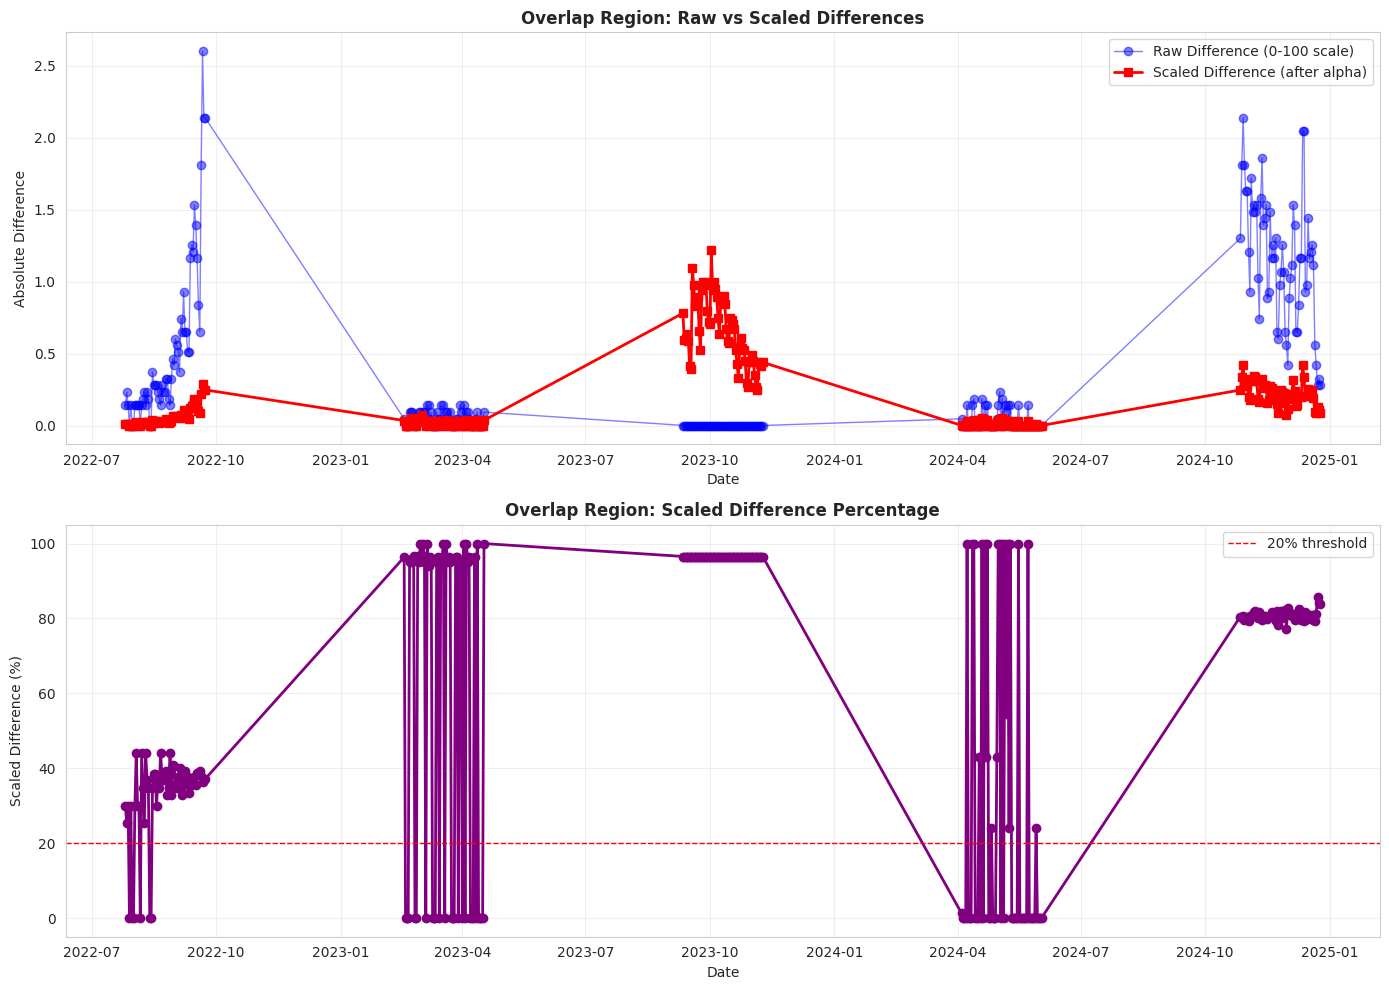

In [18]:
# Plot overlap discrepancies
if len(overlap_df) > 0:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    # Subplot 1: Raw vs scaled differences
    ax1.plot(overlap_df["date"], overlap_df["raw_diff"], marker="o", linewidth=1,
             color="blue", alpha=0.5, label="Raw Difference (0-100 scale)")
    ax1.plot(overlap_df["date"], overlap_df["scaled_diff"], marker="s", linewidth=2,
             color="red", label="Scaled Difference (after alpha)")

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Absolute Difference")
    ax1.set_title("Overlap Region: Raw vs Scaled Differences", fontsize=12, fontweight="bold")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Subplot 2: Scaled difference percentage
    ax2.plot(overlap_df["date"], overlap_df["scaled_diff_pct"], marker="o", linewidth=2, color="purple")
    ax2.axhline(y=20, color="red", linestyle="--", linewidth=1, label="20% threshold")

    ax2.set_xlabel("Date")
    ax2.set_ylabel("Scaled Difference (%)")
    ax2.set_title("Overlap Region: Scaled Difference Percentage", fontsize=12, fontweight="bold")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    overlap_path = fm.get_report_path("chunk_overlap_analysis.png")
    # fig.savefig(overlap_path, dpi=300, bbox_inches="tight")
    # print(f"✓ Saved: {overlap_path}")
    plt.show()
else:
    print("⚠ No overlap data to plot")

## 9. Generate Reports

### 9.1 Export CSV

In [ ]:
# Export chunk results to CSV
csv_path = fm.get_report_path("chunk_diagnostics_hierarchical.csv")
chunk_results.to_csv(csv_path, index=False)
print(f"✓ Saved: {csv_path}")

### 9.2 Generate Text Report

In [ ]:
# Generate comprehensive text report
report_lines = []
report_lines.append("=" * 80)
report_lines.append("PER-CHUNK DIAGNOSTIC ANALYSIS - HIERARCHICAL METHOD")
report_lines.append("=" * 80)
report_lines.append("")
report_lines.append(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
report_lines.append(f"Search Term: {config.search_term}")
report_lines.append(f"Date Range: {config.date_range.start} to {config.date_range.end}")
report_lines.append(f"Number of Chunks: {num_chunks}")
report_lines.append("")
report_lines.append("-" * 80)
report_lines.append("OVERALL VALIDATION METRICS (Full Stitched Series)")
report_lines.append("-" * 80)
report_lines.append(f"Weekly MAE: {diagnostics['weekly_mae']:.2f}")
report_lines.append(f"Weekly Correlation: {diagnostics['weekly_corr']:.3f}")
report_lines.append(f"Weekly NMAE: {diagnostics['weekly_nmae']:.1f}%")
report_lines.append(f"Weekly Bias: {diagnostics['weekly_bias_pct']:+.1f}%")
report_lines.append(f"Alpha CV: {diagnostics['alpha_cv']:.1f}%")
report_lines.append("")
report_lines.append("-" * 80)
report_lines.append("PER-CHUNK SUMMARY")
report_lines.append("-" * 80)
report_lines.append("")

for _, row in chunk_results.iterrows():
    chunk_id = row["chunk_id"]
    report_lines.append(f"Chunk {chunk_id}:")
    report_lines.append(f"  Date Range: {row['start_date'].date()} to {row['end_date'].date()} ({row['num_days']} days)")
    report_lines.append(f"  Alpha: {row['alpha']:.4f}")
    report_lines.append(f"  Weeks Validated: {row['num_weeks']}")
    report_lines.append(f"  Correlation: {row['correlation']:.3f}")
    report_lines.append(f"  MAE: {row['mae']:.2f}")
    report_lines.append(f"  NMAE: {row['nmae']:.1f}%")
    report_lines.append(f"  Bias: {row['bias_pct']:+.1f}%")
    report_lines.append(f"  Zero %: {row['zero_pct']:.1f}%")
    report_lines.append(f"  MAE Contribution: {row['mae_contrib']:.2f}")
    
    # Flags
    flags = []
    if row["alpha_outlier"]:
        flags.append("Alpha Outlier")
    if row["low_correlation"]:
        flags.append("Low Correlation (<0.85)")
    if row["high_nmae"]:
        flags.append("High NMAE (>5%)")
    if row["high_bias"]:
        flags.append("High Bias (>10%)")
    
    if flags:
        report_lines.append(f"  ⚠ FLAGS: {', '.join(flags)}")
    else:
        report_lines.append(f"  ✓ No quality flags")
    
    report_lines.append("")

report_lines.append("-" * 80)
report_lines.append("OVERLAP ANALYSIS")
report_lines.append("-" * 80)
if len(overlap_df) > 0:
    report_lines.append(f"Total Overlap Dates: {len(overlap_df)}")
    report_lines.append(f"Mean Scaled Difference: {overlap_df['scaled_diff'].mean():.2f}")
    report_lines.append(f"Mean Scaled Difference %: {overlap_df['scaled_diff_pct'].mean():.1f}%")
    report_lines.append(f"Max Scaled Difference: {overlap_df['scaled_diff'].max():.2f}")
    report_lines.append(f"Dates with >20% Difference: {(overlap_df['scaled_diff_pct'] > 20).sum()}")
else:
    report_lines.append("No overlap dates found.")
report_lines.append("")

report_lines.append("-" * 80)
report_lines.append("PROBLEMATIC CHUNKS")
report_lines.append("-" * 80)
problematic = chunk_results[chunk_results["flags"] > 0]
if len(problematic) > 0:
    report_lines.append(f"Found {len(problematic)} chunk(s) with quality flags:")
    for _, row in problematic.iterrows():
        report_lines.append(f"  - Chunk {row['chunk_id']}: {row['flags']} flag(s)")
else:
    report_lines.append("✓ No problematic chunks detected. All chunks meet quality thresholds.")
report_lines.append("")

report_lines.append("-" * 80)
report_lines.append("INTERPRETATION GUIDE")
report_lines.append("-" * 80)
report_lines.append("")
report_lines.append("Expected Quality Thresholds:")
report_lines.append("  - Correlation: > 0.85 (pattern similarity after alpha scaling)")
report_lines.append("  - NMAE: < 5% (scale-invariant accuracy)")
report_lines.append("  - Bias %: within ±10% (no systematic over/under prediction)")
report_lines.append("  - Alpha: 0.1 to 10 (reasonable scaling factor)")
report_lines.append("")
report_lines.append("Common Issues:")
report_lines.append("  - Low Correlation: Pattern mismatch, may indicate Google rebasing or noisy data")
report_lines.append("  - High NMAE: Large errors relative to data range")
report_lines.append("  - High Bias: Systematic offset, chunk consistently over/under predicts")
report_lines.append("  - Alpha Outlier: Extreme scaling factor, may indicate data quality issue")
report_lines.append("")
report_lines.append("IMPORTANT: This is a diagnostic tool. Weekly MAE on the full stitched series")
report_lines.append("remains the primary validation metric for method comparison.")
report_lines.append("")
report_lines.append("=" * 80)

report_text = "\n".join(report_lines)

# Save report
report_path = fm.get_report_path("chunk_diagnostics_hierarchical.txt")
with open(report_path, "w") as f:
    f.write(report_text)

print(f"✓ Saved: {report_path}")
print("\n" + "="*80)
print("REPORT PREVIEW")
print("="*80)
print(report_text)

## 10. Summary and Conclusions

In [ ]:
print("\n" + "="*80)
print("CHUNK DIAGNOSTICS COMPLETE")
print("="*80)
print("")
print(f"✓ Analyzed {num_chunks} chunks")
print(f"✓ Generated 4 visualizations")
print(f"✓ Exported CSV and text reports")
print("")
print(f"Problematic chunks: {len(problematic)} / {num_chunks}")
print(f"Overall Weekly MAE: {diagnostics['weekly_mae']:.2f}")
print("")
print("Next Steps:")
print("  1. Review problematic chunks (if any) for data quality issues")
print("  2. Consider increasing overlap for chunks with high error contribution")
print("  3. Investigate chunks with low correlation for potential Google rebasing")
print("  4. Proceed to robustness testing (nb/05_robustness_testing.ipynb)")
print("")
print("Generated Files:")
print(f"  - {report_path}")
print(f"  - {csv_path}")
print(f"  - {heatmap_path}")
print(f"  - {timeline_path}")
print(f"  - {error_path}")
if len(overlap_df) > 0:
    print(f"  - {overlap_path}")
print("="*80)